# HW2


Before submitting your **HTpy-HW2.ipynb** file, perform the following
* `Kernel>Restart & Run All`
* Make sure that there are no errors

The following includes problems that need coding and others that only need to perform simple operations (python as a calculator).

In [15]:
from Libraries import thermodynamics as thermo
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as csts

## 1 Insulation

This problem is an expansion of PB 3 in `HTpy-HW2.ipynb`

Assuming that the outer surface temperature of the pipe is $150^\circ C$, find an insulation that works (i.e. an insulation that will not melt, for which you can find the price and thermal conductivity online). Derive the necessary equations that allow for determination of the different costs as a function of the thickness. Generate a plot for at least 3 different thicknesses.

Hint: Derive the heat loss for a variable thickness of insulation, then apply this formula for a range of thicknesses. Compare savings of gas vs cost of insulation.

<img src=https://raw.githubusercontent.com/yvesdubief/UVM-ME144-Heat-Transfer/master/HW2-pipe.png alt="my awesome sketch" width=50% >


#### Assumptions:
* Heat transfer is steady and 1D</li>

#### Insulation
The insulation is fiberglass. Its thermal conductivity is found here (http://commercial.owenscorning.com/assets/0/321/401/a0d67fd7-c5f6-4eda-8a95-9de806fe3541.pdf) as a function of mean temperature. The thermal conductivity is approximated to $k=0.04\mathrm{W}/\mathrm{m.L}$

#### Equations

The inner surface temperature of the insulation is at temperature $T_{s,i}=150^\circ\mathrm{C}$. The temperature on the outer surface of the insulation, $T_{s,o}$ is unknown. The ambient air is at $T_\infty=T_{sur}=25^\circ \mathrm{C}$, the convection coefficient of the air flow is $h=10\mathrm{W}/\mathrm{m}^2.\mathrm{K}$ and the emissivity of the insulation is assumed to be the same as the pipe (for no better reason, that it was not made available) $\varepsilon=0.8$.

Conservation of energy at the outer surface of the insulation dictates 
$$
q_{cond}=q_{conv}+q_{rad}
$$
or
$$
\frac{1}{R_{cond}}(T_{s,i}-T_{s,o})=hA(T_{s,o}-T_\infty)+\varepsilon \sigma A(T_{s,o}^4 - T_{sur}^4)
$$

with
$$
R_{cond} = \cfrac{\ln\cfrac{r_o}{r_i}}{2\pi k L},
$$
$r_i = 0.05\mathrm{m}$, $L=25m$ and $A = 2\pi r_oL$. Three thicknesses of the insulation $r_o-r_i$ are investigated. According to the manufacturer, for a $10\mathrm{cm}\simeq4\mathrm{in}$, the $1/2,1,1.5,2\mathrm{in}$ thick sheets are available at a cost of $\$16.28,18.5,25.72,36.94$ per $3\mathrm{ft}\simeq 1\mathrm{m}$, according to https://www.grainger.com/category/plumbing/insulation/pipe-insulation?attrs=Fits+Pipe+Size+-+Pipe+Insulation%7C4+in&filters=attrs . In the equation derived above, the only unknown is $T_{s,o}$ which is the solution of the following fourth order polynomial:

$$
\varepsilon\sigma A(T_{s,o}^4 - T_{sur}^4)+hA(T_{s,o}-T_\infty)-\frac{1}{R_{cond}}(T_{s,i}-T_{s,o})=0
$$

which is solved using `scipy.optimize` by setting the following function, called a residual:
$$
\mathcal{R}(T_{s,o})=\varepsilon\sigma A(T_{s,o}^4 - T_{sur}^4)+hA(T_{s,o}-T_\infty)-\frac{1}{R_{cond}}(T_{s,i}-T_{s,o})
$$
The `fsolve` algorithm finds $T_{s,o}$ such that $\mathcal{R}(T_{s,o})=0$

#### Cost for year one

For each thickness, the yearly cost $\mathrm{YC}$ is calculated from the heat rate in the insulation, since $T_{s,o}$ is known,
$$
q_{loss}=\frac{1}{R_{cond}}(T_{s,i}-T_{s,o})
$$
multiplied by a year, divided by the furnace efficiency $\eta_f = 0.9$ and multiplied by the cost of natural gas $0.02\$/\mathrm{MJ}$.
$$
\mathrm{YC}=\frac{q_{loss}(365\times24\times3600)}{\eta_f}0.02\times10^{-6}
$$

The total cost is therefore the sum of $\mathrm{YC}$ and the cost of insulation material. 

 

In [2]:
from Libraries import thermodynamics as thermo
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as csts
from scipy.optimize import fsolve
r_i = 0.05 #m
L = 25 #m
k = 0.04 #W/m.K
Nthicknesses = 4 #number of thicknesses investigated
r_o_array = (np.array([0.5, 1., 1.5, 2.])*0.0254)+r_i #m
cost_per_m = np.array([16.28, 18.5, 25.72, 36.94])
material_cost = cost_per_m*25
total_cost = cost_per_m*L
T_si = 150. #C
T_infty = T_sur = 25. #C
h = 10 #W/m^2.K
eps = 0.8
Cost = 0.02
def R_cyl(ro,ri,k,L):
    return np.log(ro/ri)/(2*np.pi*k*L)
def consofE(Ts):
    global R_cond_ins,A,h,T_infty,eps,T_si
    residual = eps*csts.sigma*A*(thermo.C2K(Ts)**4 - thermo.C2K(T_infty)**4) \
            + h*A*(Ts-T_infty) \
            - (1/R_cond_ins)*(T_si-Ts)
#     residual = + h*A*(Ts-T_infty) - (1/R_cond_ins)*(T_si-Ts)
    return  residual
T_so = np.zeros(Nthicknesses)
heatloss_cost = np.zeros(Nthicknesses)
for n in range(Nthicknesses):
    r_o = r_o_array[n]
    A = 2*np.pi*r_o*L
    R_cond_ins = R_cyl(r_o,r_i,k,L)
    root = fsolve(func=consofE,x0=[50.])
    T_so[n] = root[0]
    print("Verification R(T_so=%0.1f C): %.2e, for thickness %i" %(T_so[n],consofE(T_so[n]),n+1))
    q = (1./R_cond_ins)*(T_si - T_so[n])
    
    heatloss_cost[n] = q*(365*24*3600)/0.9*Cost*1e-6
    print("Heat loss: %.0f W" %(q))
    print("Y 1 energy cost: $%.0f, Material cost: $%.0f, Total cost: $%.0f" %(heatloss_cost[n],material_cost[n],heatloss_cost[n]+material_cost[n]))

Verification R(T_so=44.4 C): 9.09e-13, for thickness 1
Heat loss: 2930 W
Y 1 energy cost: $2053, Material cost: $407, Total cost: $2460
Verification R(T_so=34.9 C): 1.14e-12, for thickness 2
Heat loss: 1761 W
Y 1 energy cost: $1234, Material cost: $462, Total cost: $1697
Verification R(T_so=31.4 C): 6.82e-13, for thickness 3
Heat loss: 1316 W
Y 1 energy cost: $922, Material cost: $643, Total cost: $1565
Verification R(T_so=29.6 C): 6.82e-13, for thickness 4
Heat loss: 1079 W
Y 1 energy cost: $756, Material cost: $924, Total cost: $1680


In Year 1, the optimum solution is $1\,1/2\;\mathrm{in}$ thick-insulation. The thicker insulation costs more than the cost of gas.

### ROI

Insulation is a one-time cost. Overlooking the insanity of having an unearthed $25\mathrm{m}$ steam pipe, insulating material is supposed to last longer than one year. Upgrading to $2\;\mathrm{in}$ thickness is a better return on investment (ROI) as soon as Year 2 and beyond. 

Note the tenfold decrease in energy cost comparted to no insulation. This problem is representative of the type of decision you will have to make and justify to a diverse audience. You should be confident in your solution but remember that the vast majority of the audience just wants to know how to save the most. A graph is often a more powerful vehicle for your argument than text and speech. 

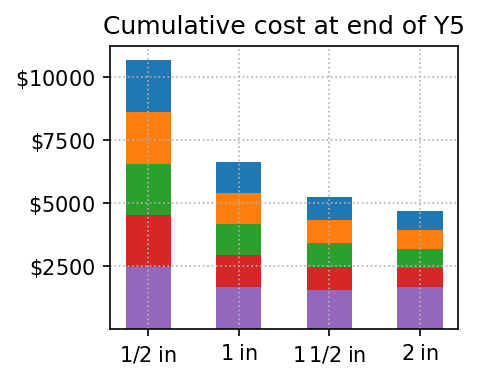

In [3]:
thicknesses = [r"$1/2\;\mathrm{in}$", r"$1\;\mathrm{in}$",r"$1\,1/2\;\mathrm{in}$",r"$2\;\mathrm{in}$" ]
Nyears = 5
years = ["Y1", "Y2", "Y3", "Y4", "Y5"]
dollars_str = [r"$\$2500$", r"$\$5000$", r"$\$7500$", r"$\$10000$"]
dollars_int = np.arange(2500,10001,2500)
cumul_cost = np.zeros((Nthicknesses,Nyears))
for iyear in range(Nyears):
    cumul_cost[:,iyear] = (iyear + 1)*heatloss_cost[:]+material_cost[:]
# plt.plot(thicknesses,heatloss_cost)
# plt.plot(thicknesses,cost_per_m*L)
# plt.figure(figsize=(3,2.5),dpi=150)
# for n in range(Nthicknesses):
#     plt.plot(years,cumul_cost[n,:], label=thicknesses[n])#/cumulative_cost[0])
# plt.xticks(years)
# plt.yticks(dollars_int,dollars_str)
# plt.title("Cumulative cost")
# plt.legend()
# plt.show()
width = 0.5
indx = np.arange(Nthicknesses)
plt.figure(figsize=(3,2.5),dpi=150)
for i in range(4,-1,-1):
    plt.bar(indx,cumul_cost[:,i],width)#/cumulative_cost[0])
plt.xticks(indx,thicknesses)
plt.yticks(dollars_int,dollars_str)
plt.title("Cumulative cost at end of Y5")
plt.grid(True,linestyle = 'dotted')
plt.show()

### Optional verification
A quick verification is to compute the outer surface temperature in the absence of radiation. These temperatures should higher, yet not too far from the temperature found above.

In [4]:
for n in range(Nthicknesses):
    r_o = r_o_array[n]
    A = 2*np.pi*r_o*L
    R_cond_ins = R_cyl(r_o,r_i,k,L)
    T_so[n] = (h*A*T_infty + T_si/R_cond_ins)/(h*A+1/R_cond_ins)
T_so

array([52.48548442, 39.29668845, 34.27571448, 31.69591197])

### If we want to be picky
The thermal conductivity is a function of the mean temperature
$$
T_{mean}=\frac{T_{si}+T_{so}}{2}
$$
as shown in the graph below:

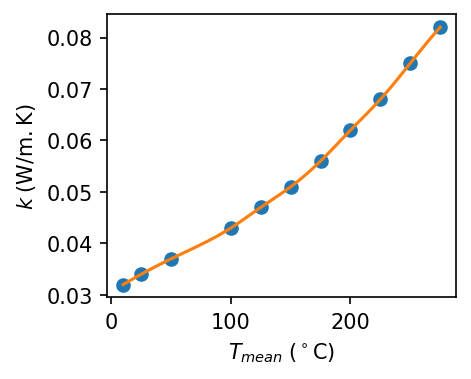

In [5]:
from scipy.interpolate import interp1d

meanT = np.array([10,25,50,100,125
                  ,150,175,200,225,250,275])
k_ins = np.array([0.032, 0.034,0.037,0.043,
                  0.047,0.051,0.056,
                  0.062,0.068,0.075,0.082])
meanTint = np.linspace(meanT[0],meanT[-1],100)
fk_ins = interp1d(meanT,k_ins,kind='cubic')
plt.figure(figsize=(3,2.5),dpi=150)
plt.plot(meanT,k_ins,'o')
plt.plot(meanTint,fk_ins(meanTint))
plt.xlabel(r"$T_{mean}\;(^\circ\mathrm{C})$")
plt.ylabel(r"$k\; (\mathrm{W/m.K})$")
plt.show()

The graph plots the data provided by the manufacturer (blue dot) and the interpolated function (line). The latter becomes part of the residual function to be solved.

In [6]:
from Libraries import thermodynamics as thermo
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as csts
from scipy.optimize import fsolve
r_i = 0.05 #m
L = 25 #m
Nthicknesses = 4 #number of thicknesses investigated
r_o_array = (np.array([0.5, 1., 1.5, 2.])*0.0254)+r_i #m
cost_per_m = np.array([16.28, 18.5, 25.72, 36.94])
material_cost = cost_per_m*25
total_cost = cost_per_m*L
T_si = 150. #C
T_infty = T_sur = 25. #C
h = 10 #W/m^2.K
eps = 0.8
Cost = 0.02
def R_cyl(ro,ri,k,L):
    return np.log(ro/ri)/(2*np.pi*k*L)
def consofE(Ts):
    global r_o,r_i,L,A,h,T_infty,eps,T_si,fk_ins
    T_mean = (T_si + Ts)/2.
    R_cond_ins = R_cyl(r_o,r_i,fk_ins(T_mean),L)
    residual = eps*csts.sigma*A*(thermo.C2K(Ts)**4 - thermo.C2K(T_infty)**4) \
            + h*A*(Ts-T_infty) \
            - (1/R_cond_ins)*(T_si-Ts)
#     residual = + h*A*(Ts-T_infty) - (1/R_cond_ins)*(T_si-Ts)
    return  residual
T_so = np.zeros(Nthicknesses)
heatloss_cost = np.zeros(Nthicknesses)
for n in range(Nthicknesses):
    r_o = r_o_array[n]
    A = 2*np.pi*r_o*L
    root = fsolve(func=consofE,x0=[50.])
    T_so[n] = root[0]
    T_mean = 0.5*(T_so[n] + T_si)
    print("Verification R(T_so=%0.1f C): %.2e, for thickness %i" %(T_so[n],consofE(T_so[n]),n+1))
    q = (1./R_cyl(r_o,r_i,fk_ins(T_mean),L))*(T_si - T_so[n])
    
    heatloss_cost[n] = q*(365*24*3600)/0.9*Cost*1e-6
    print("Heat loss: %.0f W" %(q))
    print("Y 1 energy cost: $%.0f, Material cost: $%.0f, Total cost: $%.0f" %(heatloss_cost[n],material_cost[n],heatloss_cost[n]+material_cost[n]))

Verification R(T_so=45.5 C): 2.27e-12, for thickness 1
Heat loss: 3095 W
Y 1 energy cost: $2169, Material cost: $407, Total cost: $2576
Verification R(T_so=35.3 C): 9.09e-13, for thickness 2
Heat loss: 1840 W
Y 1 energy cost: $1290, Material cost: $462, Total cost: $1752
Verification R(T_so=31.6 C): -6.82e-13, for thickness 3
Heat loss: 1370 W
Y 1 energy cost: $960, Material cost: $643, Total cost: $1603
Verification R(T_so=29.7 C): -2.27e-13, for thickness 4
Heat loss: 1121 W
Y 1 energy cost: $785, Material cost: $924, Total cost: $1709


In [7]:
fk_ins(0.5*(T_si+T_so))

array([0.0426718 , 0.04196247, 0.04171504, 0.04159221])

The largest difference is an error in the total cost for Y1 of around $\$100$ or $4.5\%$ for the smallest thickness. In this particular case, the original approximation using $k=0.04\;\mathrm{W/m.K}$ is sufficient. 

#### Solution with thermal circuit (not asked)

The following solution is a different way to solve the problem

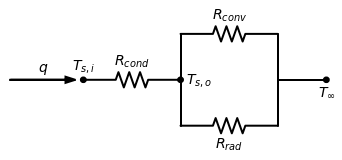

In [17]:
from Libraries import HT_thermal_resistance as res
import schemdraw as schem
import schemdraw.elements as e

R = []
R.append(res.Resistance("$R_{cond}$", "W"))
R.append(res.Resistance("$R_{conv}$", "W"))
R.append(res.Resistance("$R_{rad}$", "W"))

d = schem.Drawing()
d.add(e.DOT, label = r"$T_{s,i}$")
R1 = d.add(e.RES, d = 'right', label = R[0].name)
d.add(e.DOT, rgtlabel = r"$T_{s,o}$")
d.add(e.LINE, d= 'up', l = 1.5)
d.add(e.RES, d='right', label = R[1].name)
d.add(e.LINE, d='down', l = 1.5)
d.add(e.LINE, d='down', l = 1.5, xy = R1.end)
d.add(e.RES, d='right', botlabel = R[2].name)
d.add(e.LINE, d= 'up', l = 1.5)
d.add(e.LINE,d='right',l=1.5)
d.add(e.DOT, botlabel="$T_\infty$")

L1 = d.add(e.LINE, toplabel = "$q$", endpts = [[-2.25, 0], [-0.25, 0]])
d.labelI(L1, arrowofst = 0)
d.draw()

In [20]:
r_i = 0.05 #m
L = 25 #m
Nthicknesses = 4 #number of thicknesses investigated
r_o_array = (np.array([0.5, 1., 1.5, 2.])*0.0254)+r_i #m
cost_per_m = np.array([16.28, 18.5, 25.72, 36.94])
material_cost = cost_per_m*25
total_cost = cost_per_m*L
T_si = 150. #C
T_infty = T_sur = 25. #C
h = 10 #W/m^2.K
eps = 0.8
Cost = 0.02
T_so = np.zeros(Nthicknesses)
heatloss_cost = np.zeros(Nthicknesses)
for n in range(Nthicknesses):
    
    r_o = r_o_array[n]
    
    A = 2*np.pi*r_o*L
    T_so_it = 50.
    iteration = 0
    error = np.inf
    while (error > 0.01) and (iteration < 10):
        T_so_it_old = T_so_it
        T_mean = 0.5*(T_so_it + T_si)
        # Computing individual resistances
        R[0].cond_cylinder(fk_ins(T_mean),r_i,r_o,L)
        R[1].convection(h,A)
        R[2].radiation(eps,thermo.C2K(T_so_it),thermo.C2K(T_sur),A)
        # Reducing the circuit to one resitance
        R_out = (1/R[1].R + 1/R[2].R)**(-1)
        R_total = R[0].R + R_out
        # total heat rate
        q = (T_si - T_infty)/R_total
        # Compute new T_so q_cond = (1/R_cond)(T_si - T_so) = q => T_so = T_si - R_cond*q 
        T_so_it = T_si - R[0].R*q
        # Compute error between previous iteration and this one
        print(T_so_it)
        error = abs(T_so_it - T_so_it_old)
        iteration += 1
    if iteration == 10:
        print("thickness %i solution is not converged" %n)
    else:
        print("thickness %i solution converged in %i iterations" %(n,iteration))
    T_so[n] = T_so_it
    
    heatloss_cost[n] = q*(365*24*3600)/0.9*Cost*1e-6
    print("Heat loss: %.0f W" %(q))
    print("Y 1 energy cost: $%.0f, Material cost: $%.0f, Total cost: $%.0f" %(heatloss_cost[n],material_cost[n],heatloss_cost[n]+material_cost[n]))

45.49677214323043
45.4994278937273
45.49942595453531
45.49942595595111
thickness 0 solution converged in 4 iterations
Heat loss: 3095 W
Y 1 energy cost: $2169, Material cost: $407, Total cost: $2576
35.307024339870026
35.314115958682606
35.31411112048687
35.3141111237873
thickness 1 solution converged in 4 iterations
Heat loss: 1840 W
Y 1 energy cost: $1290, Material cost: $462, Total cost: $1752
31.603632299620372
31.610086365657068
31.610083142406936
31.610083144016556
thickness 2 solution converged in 4 iterations
Heat loss: 1370 W
Y 1 energy cost: $960, Material cost: $643, Total cost: $1603
29.736583115506548
29.741979023875047
29.74197698062781
29.741976981401493
thickness 3 solution converged in 4 iterations
Heat loss: 1121 W
Y 1 energy cost: $785, Material cost: $924, Total cost: $1709


In [19]:
T_so

array([45.49942789, 35.31411596, 31.61008637, 29.74197902])

## 2 Window

Set up equations and apply realistic numerical values to them to discuss heat losses of a single pane window, a single pane window with storm window and a double paned window with air trapped at a vacuum of $10^{-3} \mathrm{torr}$ ina gap of $5\mathrm{mm}$. Do not consider the effects of radiation for any of the window.

<img src="ThermalCondAir.png" alt="my awesome sketch" width=100% >

#### Assumptions:
* Heat transfer is steady and 1D
* Radiation is ignored
* Convection in the gap of the storm window is neglected
* The temperature on the inside and outside surfaces of any window are isothermal and equal to $T_{si}=10^\circ\mathrm{C}$ and $T_{so}=-10^\circ\mathrm{C}$, respectively.
* For the storm window, and the double pane window, the average temperature in the gap between the two glass pane is assumed to the average of $T_{si}$ and $T_{so}$ or $T_{mean}=0^\circ\mathrm{C}$.

#### Setup

<img src="HW2-single-pane.png" alt="my awesome sketch" width=30% ><img src="HW2-double-pane.png" alt="my awesome sketch" width=30% >

The goal is to compute the heat loss from a model window under controlled conditions. We choose to fix the inside surface temperature to $10^\circ\mathrm{C}$ and the outside surface temperature to $-10^\circ\mathrm{C}$ for a window of height and width $h = 1.2\;\mathrm{m}$ and $w = 0.7\;\mathrm{m}$ with a surface aera $A=h\times w$. The thickness of a residential window pane is $t_{glass}=3/32\,\mathrm{in}$ (https://ringerwindows.com/thick-glass-windows/) with a thermal conductivity $k=0.96\;\mathrm{W/m.K}$. The storm window has a $2.5\,\mathrm{in}$.

The heat rate for a single window pane is
$$
q_{glass}=\frac{k_{glass}A}{t_{glass}}(T_{si}-T_{so})=\frac{1}{R_{glass}}(T_{si}-T_{so})
$$
In any gas gap (storm window or double pane with vacuum), the heat rate is
$$
q_{gap}=\frac{k_{gas}A}{t_{gap}}(T_{si,gap}-T_{so,gap})=\frac{1}{R_{gap}}(T_{si,gap}-T_{so,gap})
$$
For the storm window and double pane window, the total resistance and heat loss are, respectively,
$$
R_{total}=R_{glass}+R_{gap}+R_{glass},
$$
and,
$$
q=\frac{1}{R_{total}}(T_{si}-T_{so})
$$

In [10]:
3/32*0.0254

0.0023812499999999997

In [11]:
import numpy as np
from Libraries import thermodynamics as thermo
T_si = 10. #C
T_so = -10. #C
h = 1.2 #m
w = 0.7 #m
t_glass = 3./32.*0.0254 #m
k_glass = 0.96
A = h*w
t_gap_storm = 2*0.0254 #m
air_gap_storm = thermo.Fluid('air',thermo.C2K(0.))
t_gap_vacuum = 0.005#m
k_vacuum = 0.003 #W/m.K (from graph)
R_glass = t_glass/(k_glass * A)
R_gap_storm = t_gap_storm/(air_gap_storm.k * A)
R_gap_vacuum = t_gap_vacuum/(k_vacuum * A)
R_total_single = R_glass
R_total_storm = 2 * R_glass + R_gap_storm
R_total_double = 2 * R_glass + R_gap_vacuum

print("Thermal conductivity of air at 0 C: %.4f" %air_gap_storm.k)
print("Thermal resistance for the single window: %.4f K/W" %R_total_single)
print("Thermal resistance for the storm window: %.4f K/W" %R_total_storm)
print("Thermal resistance for the double pane window: %.4f K/W" %R_total_double)

DT = T_si - T_so
q_single = DT/R_total_single
q_storm = DT/R_total_storm
q_double = DT/R_total_double
print("Single window pane q: %.0f W" %q_single)
print("Storm window q: %.0f W" %q_storm)
print("Double pane window q: %.0f W" %q_double)

Thermal conductivity of air at 0 C: 0.0243
Thermal resistance for the single window: 0.0030 K/W
Thermal resistance for the storm window: 2.4946 K/W
Thermal resistance for the double pane window: 1.9900 K/W
Single window pane q: 6773 W
Storm window q: 8 W
Double pane window q: 10 W


Storm and double pane windows are vastly superior to single pane window. The storm window however is not as efficient as this example seems to indicate, but still a lot better than single pane windows.

In [12]:
thermo.C2F(8)

46.4

In [14]:
def f(x):
    return np.pi*(0.0006)*0.9*csts.sigma*(x**4 - 293**4) + 1.25*np.pi*(0.0006)**(3/4)*(x-293)**(5/4) - 4
fsolve(f,307.)

array([362.86950839])